# Introduction to Simpy: discrete event simulation in Python
The python package `Simpy` provides a convenient way to program discrete event simulation that incorporate resources with limited capacity. This tutorial provides somes of the basics to use the package.

Check the [simpy website](https://simpy.readthedocs.io/en/latest/) for instructions on how to install `simpy` in your computer (be careful not to confuse it with the `sympy` package, which is different and focus on symbolic algebra).

The tutorial is organized as follows:

- Introduction to generator functions
- Basic syntax of simpy
- Example of queing system

## Generator functions

You are probably familiar with using functions in Python. Generators are defined using similar syntax as functions but are used in a different way. 

When calling a function, it is executed "from scratch" every time it is called. Consider the following function.

In [66]:
def add_series(n):
    num=0
    tot=0
    while num<n:
        tot += num
        num += 1
    return tot

result = add_series(10)
print(result)

45


This is a simple function that adds all integers from 0..n and returns the result. Now, consider a variation of this function that **incrementally** adds the integers every time the function is called. This is an example of a generator.

In [67]:
def add_series_gen(n):
    num=0
    tot=0
    while num<n:
        tot += num
        num += 1
        yield tot

mygen = add_series_gen(10)
print("First call: %s"%(next(mygen)))
print("Second call: %s"%(next(mygen)))
print("Third call: %s"%(next(mygen)))

First call: 0
Second call: 1
Third call: 3


The `yield` command is similar to a `return` in that is returns a value when the function is called; however, the function "remembers" the point at which it returned the value and proceed from that point on the next time it is called. The `next` command tells the generator to resume execution from where it was until the next `yield` statement is returned.

In simpy, generators are used to create entities in the simulation, which is useful to keep track of the state of the entity during the simulation as the clock moves on.

## Basics of simpy
We will use two basic elements in the simpy simulation API:

- The simpy Environment: this is what controls the simulation clock and "orquestrates" the flow of entities through the system.
- Resources: used to capture limited resources which entities use. When resources are busy, entities that request the use of that resource will have to wait until it becomes available.

For our example, consider a bank with two ATM machines. The object `env` is defined as the enviroment and the `atm` as a resources with 2 units of capacity (the two machines).

In [68]:
import simpy

# init the enviroment
env = simpy.Environment()
# define the resources
NSERVERS = 2
atm = simpy.Resource(env,capacity=NSERVERS)


We now define an entity and how it flows through the system. These are defined through a generator that receives as input the simpy environment that will manage the flow of the entity and the ATM resources that he will use. We also provide the arrival time and the service time of the customer (how long he uses the ATM machine), and his name.

In [69]:
def cust(env,atm,name,arrival_t,service_t):
    yield env.timeout(arrival_t)
    print('%s arriving at %d' %(name,env.now))
    
    # Request the use of the resource
    req = atm.request()
    yield req
    print('%s starts service at %s  (waited %s)' %(name, env.now,env.now-arrival_t))
    # The customer holds the resource during the service time
    yield env.timeout(service_t)
    print('%s finishes service at %s' %(name, env.now))
    # release the resource
    atm.release(req)


Notice the different `yield` statements inside the generator. The first `yield` tells the environment to call back the generator later in time, after a `timeout` of `arrival_t` time units. When the `env` calls the generator back again, it resumes from that point onwards. The `env.now` is a variable of the environment object that keeps track of the clock.

Then, the generator defines `req` as a request of the ATM resource (`atm.request()`). A new `yield` command is called to make the request, and the enviroment will call back the generator as soon as the resource is idle (which could be inmediately). The generator resumes and then a new `yield` is move the clock while the customer is using the resource. After the generator resumes, the resources is released, and can therefore be used to fill the request of another customer process.

To execute the simulation, we generate customer arrivals and service times. We use the `numpy` package to generate these random variables according to an exponential distribution. The customer process are "scheduled" using the `env.process()` function of the environment object.

In [70]:
import numpy as np
# Schedule the customer arrivals
t= 0
NCUST = 10
ARRIVALRATE = (1/50) * 2  
SERVICERATE = 1/40
# set the seed for random number generation
SEED = 777
np.random.seed(SEED)

for i in range(NCUST):
    service_time = round(np.random.exponential(1/SERVICERATE))
    # interarrival times
    intertime = round(np.random.exponential(1/ARRIVALRATE))
    # pass the customer entity to be processed in the environment
    env.process(cust(env,atm,'C%d'%i, t + intertime, service_time))
    t = t + intertime


Finally, we tell the environment to run the simulation with all the processes that were scheduled. The output shows the arrival times, the time each customer starts service and finishes.

In [71]:
env.run()

C0 arriving at 9
C0 starts service at 9  (waited 0)
C0 finishes service at 16
C1 arriving at 24
C1 starts service at 24  (waited 0)
C1 finishes service at 27
C2 arriving at 89
C2 starts service at 89  (waited 0)
C3 arriving at 126
C3 starts service at 126  (waited 0)
C4 arriving at 152
C5 arriving at 154
C2 finishes service at 161
C4 starts service at 161  (waited 9)
C6 arriving at 165
C4 finishes service at 174
C5 starts service at 174  (waited 20)
C3 finishes service at 178
C5 finishes service at 178
C6 starts service at 178  (waited 13)
C7 arriving at 190
C7 starts service at 190  (waited 0)
C8 arriving at 210
C6 finishes service at 214
C8 starts service at 214  (waited 4)
C9 arriving at 222
C8 finishes service at 260
C9 starts service at 260  (waited 38)
C9 finishes service at 273
C7 finishes service at 370


## Example of a Queuing System

We extend the previous example to study a system with multiple queues, similar to what could be a supermarket with multiple cashiers. We also use the example to illustrate how to store relevant information of the simulation that is used as output for later analysis.

The system is composed by three cashiers with the same service time. Arrival times vary during the day, in four time blocks.


In [72]:
import simpy
import random
import numpy as np

'''
Parameters
'''
NCASHIER = 2
SERVICERATE = 1/40
SEED = 777
ARRIVALRATES = [x*NCASHIER for x in [1/100, 1/50, 1/75, 1/45]]
#ARRIVALRATES = [x*NCASHIER for x in [1/75]]

'''
Auto parameter
'''
TIME_INTERVALS = []
for i in range(len(ARRIVALRATES)):
    print(i)
    TIME_INTERVALS.append((i*3600*4, (i+1)*3600*4))
print(TIME_INTERVALS)
print(ARRIVALRATES)


'''
Set seed
'''
random.seed(SEED)
np.random.seed(SEED)

0
1
2
3
[(0, 14400), (14400, 28800), (28800, 43200), (43200, 57600)]
[0.02, 0.04, 0.02666666666666667, 0.044444444444444446]


We create a list to store the changes in the occupancy of the system. By convention, -1 indicates empty cashier, 0 is server occupied with no queue and >0 is the length of queue.

In [73]:
'''
data_occ: list storing changes in customers in the system (c,t,s).
* c is cashier code
* t is time in seconds
* s = -1 is empty, = 0 is server occupied with no queue ,> 0 is queue.
'''
data_occ = []
# start checkouts empty
for i in range(NCASHIER):
    data_occ.append((i,0,-1))


Customer entities join the system and choose which cashier to join. In this simulation, customers choose the cashier with the shortest queue. The code has a similar structure to what we had before, with some additions:

- We keep track if the customers had to join a queue or started inmediately service (variable `joinedqueue`).
- `cashiers` is a list of resources, so customers choose which resource to request
- When requesting, we now use the command `with`. This helps to keep the code organized and also makes the `release()` command unnecessary (it is automatically triggered after the `with` block is done).
- we store changes in the occupancy of each cashier when a customer joins and exits: `data_occ.append()`.


In [81]:
def cust_choose(env, name, cashiers, arrival_time, service_time):
    # client arrival
    yield env.timeout(arrival_time)
    #print('%s arriving at %d' %(name,env.now))

    # shuffle cashiers to generate choiceset, breaking ties randomly
    choiceset = list(range(NCASHIER))
    random.shuffle(choiceset)

    # choose cashier with lowest occupancy (service + queue)
    minocc = float("inf")  # infinity
    for i in choiceset:
        occ = len(cashiers[i].queue) + cashiers[i].count
        if occ < minocc:
            choice = i
            minocc = occ    
    #print('%s joins cashier %d with occ %d'%(name,choice,minocc))

    # if chosen cashier is busy
    if cashiers[choice].count==1:
       # print("%s joins queue %d."%(name,choice))
       # print("**Queue %d length increased: %d"%(choice,len(cashiers[choice].queue)+1))
        joinedqueue = True
    else:
        joinedqueue = False
        
    # requests cashier after joining
    with cashiers[choice].request() as req:
        # update occupancy data
        new = cashiers[choice].count + len(cashiers[choice].queue) - 1  # substract one by notation
        data_occ.append((choice, env.now, new))
        yield req
        #print('%s starts service in cashier %d at %s' %(name,choice,env.now))
        #if joinedqueue:
        #    print("**Queue %d length decreased: %d"%(choice,len(cashiers[choice].queue)))      
        yield env.timeout(service_time)
        #print('%s leaving the supermarket at %s' %(name,env.now))
    # **** update occupancy ***
    # recall -1 is empty, so substract one to real occupancy.
    data_occ.append((choice,env.now,len(cashiers[choice].queue)+cashiers[choice].count-1))
 


In the main program, we initialize the environment and create the cashier resources.

In [82]:
'''
Main program
'''
env = simpy.Environment()

'''
Create cacshiers
'''
cashierList = []
for _ in range(NCASHIER):
    cashierList.append(simpy.Resource(env,capacity=1))

To create arrivals, we consider the non-homogenous arrival rate during different time periods of the day. 

In [83]:
'''
Create customers, with times and add to process
* interarrival time: exp(1/SERVICERATE)
* service times: exp(1/ARRIVALRATE)
'''
k = 0
t = 0
i = 1
while k < len(TIME_INTERVALS):
    time_interval = TIME_INTERVALS[k]
    arrival_rate = ARRIVALRATES[k]
    service_time = round(np.random.exponential(1/SERVICERATE))
    intertime = round(np.random.exponential(1/arrival_rate))
    env.process(cust_choose(env,
                    'C%d'%i,
                    cashierList,
                    t + intertime,
                    service_time))
    t = t + intertime
    if t >= time_interval[1]:
        k += 1
    i+=1

Running the simulation... Output is quite long, so its surpressed in the display.

In [84]:
env.run();

The next chunk uses the `pandas` packages to export the data collected in the simulation. A `csv` file is generated showing, for each cashier, the time epochs at which the occupancy of the cashier changed. by convention. 

In [85]:
import pandas as pd
'''
Create export dataset
'''
name = "JoinShortest_q{}_s{}_varutil".format(NCASHIER,SEED)
OUTPUT = "{}.csv".format(name)
dfdata = pd.DataFrame(data=data_occ,columns=['cashier','time','occ'])
dfdata.columns = ["cashier", "time", "occ"]
#dfdata["Local"]= name
#dfdata["Fecha"] = pd.to_datetime("1/1/2020")
dfdata.to_csv(OUTPUT,index=False,header=True)

The output table, order by time, looks like this:

In [86]:
dfdata.head(10)

,cashier,time,occ
0,0,0,-1
1,1,0,-1
2,1,18,0
3,1,25,-1
4,0,49,0
5,0,52,-1
6,0,180,0
7,0,252,-1
8,0,253,0
9,1,305,0


The following code transforms the data into a format that makes it easier to visualize in a graph. It uses the `matplotlib`library to do the graph

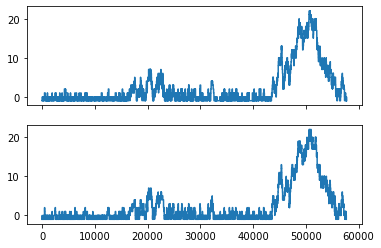

In [80]:
import matplotlib.pyplot as plt
# Function to reformat into ts to facilitate plotting
def ts_data(dfdata,cashier):
    sel_cashier = dfdata['cashier']==cashier
    seldata =  dfdata.loc[sel_cashier,['time','occ']]
    seldata.sort_values(by='time')
    
    #npdata_occ = npdata_all[npdata_all[:,0]==cashier,1:3]
    # sort by time
    #npdata_occ = npdata_occ[np.argsort(npdata_occ[:,1])]
    
    newlen = len(seldata)*2 -1
    time = list(range(newlen))
    time[0:newlen:2]=seldata.iloc[:,0]
    time[1:newlen:2]=seldata.iloc[1:,0]
    occ = list(range(newlen))
    occ[0:newlen:2]=seldata.iloc[:,1]
    occ[1:newlen:2]=seldata.iloc[0:len(seldata)-1,1]
    return (time,occ)


fig,ax = plt.subplots(NCASHIER,sharex='all',sharey='all')
for i in range(NCASHIER):
    tsqueue = ts_data(dfdata,i)
    ax[i].plot(tsqueue[0],tsqueue[1])
plt.show()

## Analyzing the output of a simulation
Consider the first example of the ATM machine with a single server. We are interested in measuring the expected time at which the last customer finishes processing.
What we showed previously is the result of *one* simulation run. To measure the outcome presented here, we need to run multiple simulations and calculate averages *across* simulations to estimate these expected values.
We recycle some of the previous code and extend it to have multiple simulations.

In [100]:
%%capture
# first line to suppress output
import numpy as np
from scipy.stats import norm

NSERVERS = 2
ARRIVALRATE = (1/50) * 2  
SERVICERATE = 1/40
NCUST = 10
# set the seed for random number generation
SEED = 777
np.random.seed(SEED)

endtime = []
# iterate runs
for i in range(100):
    # init the enviroment
    env = simpy.Environment()
    # define the resources
    atm = simpy.Resource(env,capacity=NSERVERS)
    t= 0
    for i in range(NCUST):
        service_time = round(np.random.exponential(1/SERVICERATE))
        # interarrival times
        intertime = round(np.random.exponential(1/ARRIVALRATE))
        # pass the customer entity to be processed in the environment
        env.process(cust(env,atm,'C%d'%i, t + intertime, service_time))
        t = t + intertime
    env.run()
    # save the endtime of this run
    endtime.append(env.now);
    

Now we analize the output of the simulation and construct the 95% confidence interval. Here, the relative precision is defined as the half-width of the confidence interval divided by the midpoint of the interval.

Confidence Interval = $$\bar X \pm z_\alpha S/\sqrt{R}$$
where $R$ is the number of runs.

The relative precision is defined as: $$( z_\alpha S/\sqrt{R} - \bar X)/\bar X$$

In [129]:
mean_endt = np.mean(endtime)
stdev_endt = np.std(endtime)
n = len(endtime)
z = norm.ppf(0.975)
ub = mean_endt+z*stdev_endt/np.sqrt(n)
lb = mean_endt - z*stdev_endt/np.sqrt(n)
print("Mean=%f  StDev=%f"%(mean_endt,stdev_endt))
print("Number of runs=%d"%(n))
print("95%% Confidence interval [%f,%f]"%(lb,ub))
print("Relative precision= %f"%((ub-mean_endt)/mean_endt))

Mean=319.390000  StDev=82.067764
Number of runs=100
95% Confidence interval [303.305014,335.474986]
Relative precision= 0.050362


Suppose we want to achieve a relative precision of 2%. How many runs should we execute to achieve this precision? The half-width of the interval has to be $d = 0.02\bar X$

In [130]:
d = 0.02*mean_endt
Rmin = (z*stdev_endt/d)**2
print("Minimum number of runs (precision 2%%)= %d"%(np.ceil(Rmin)))

Minimum number of runs (precision 2%)= 635
